<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/DeepGBM_(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Required packages:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow lightgbm

Make sure you have the following CSV files in your directory:
- train.csv
- validation.csv  
- test.csv

All files should have the same column structure with 'Production (M.Ton)' as the target variable.

=== DeepGBM Agricultural Production Classification ===

Train data shape: (3584, 84)
Validation data shape: (768, 84)
Test data shape: (768, 84)
Preparing training data...
Preparing validation data...
Preparing test data...

Quantile thresholds: [ 550.2   1447.52  3064.522 6362.6  ]
Label distribution in training:
  Very Low: 717 samples
  Low: 717 samples
  Medium: 716 samples
  High: 717 samples
  Very High: 717 samples

=== Training DeepGBM Model ===
Training LightGBM...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.411244	val's multi_logloss: 0.549813
Building Neural Network...
Training Neural

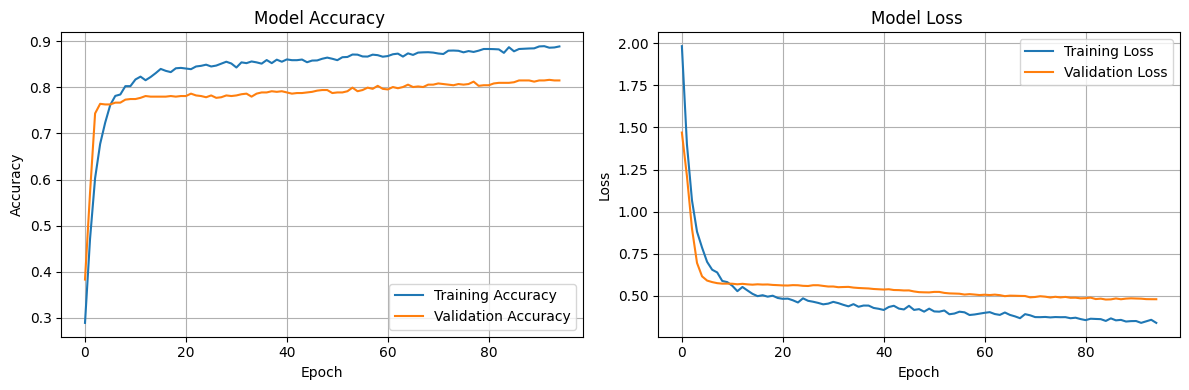


=== Overfitting Analysis ===
Average Training Accuracy (last 10 epochs): 0.8855
Average Validation Accuracy (last 10 epochs): 0.8146
Accuracy Gap: 0.0709
✅ Model appears well-balanced (gap <= 0.1)

=== Validation Results ===
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation Metrics:
  Accuracy: 0.8099
  Precision: 0.8146
  Recall: 0.8099
  F1-Score (Weighted): 0.8113
  F1-Score (Macro): 0.8106

=== Test Results ===
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Metrics:
  Accuracy: 0.8177
  Precision: 0.8199
  Recall: 0.8177
  F1-Score (Weighted): 0.8183
  F1-Score (Macro): 0.8158

=== Detailed Classification Report (Validation) ===
              precision    recall  f1-score   support

    Very Low       0.95      0.89      0.92       160
         Low       0.77      0.83      0.80       147
      Medium       0.75      0.72      0.73       153
        High       0.72      0.78      0.75       157
   Very High       0.88      0.83      0.85       151

    accuracy                     

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DeepGBM:
    """
    Deep Gradient Boosting Machine combining LightGBM with Neural Networks
    """
    def __init__(self, n_classes=5, embedding_dim=16, hidden_units=[128, 64, 32]):
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.gbm_model = None
        self.nn_model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def create_quantile_labels(self, y):
        """Create quantile-based labels for production values"""
        quantiles = np.quantile(y, [0.2, 0.4, 0.6, 0.8])
        labels = []
        label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

        for val in y:
            if val <= quantiles[0]:
                labels.append(0)  # Very Low
            elif val <= quantiles[1]:
                labels.append(1)  # Low
            elif val <= quantiles[2]:
                labels.append(2)  # Medium
            elif val <= quantiles[3]:
                labels.append(3)  # High
            else:
                labels.append(4)  # Very High

        self.label_names = label_names
        self.quantiles = quantiles
        return np.array(labels)

    def add_noise_augmentation(self, X, y, noise_factor=0.01):
        """Add slight noise to training data for augmentation"""
        noise = np.random.normal(0, noise_factor, X.shape)
        X_augmented = X + noise
        return X_augmented, y

    def prepare_data(self, df, target_col='Production (M.Ton)', is_training=True, augment=False):
        """Prepare data for training/validation/testing"""
        # Separate features and target
        if target_col in df.columns:
            X = df.drop(columns=[target_col])
            y = df[target_col].values

            if is_training:
                # Create quantile-based labels
                y_labels = self.create_quantile_labels(y)
            else:
                # Apply existing quantiles for validation/test data
                y_labels = []
                for val in y:
                    if val <= self.quantiles[0]:
                        y_labels.append(0)
                    elif val <= self.quantiles[1]:
                        y_labels.append(1)
                    elif val <= self.quantiles[2]:
                        y_labels.append(2)
                    elif val <= self.quantiles[3]:
                        y_labels.append(3)
                    else:
                        y_labels.append(4)
                y_labels = np.array(y_labels)
        else:
            X = df
            y_labels = None

        # Handle missing values
        X = X.fillna(X.mean())

        # Scale features
        if is_training:
            X_scaled = self.scaler.fit_transform(X)
            # Apply data augmentation if requested
            if augment:
                X_scaled, y_labels = self.add_noise_augmentation(X_scaled, y_labels)
        else:
            X_scaled = self.scaler.transform(X)

        return X_scaled, y_labels, X.columns.tolist()

    def build_lightgbm(self, X_train, y_train, X_val, y_val):
        """Build and train LightGBM model"""
        # LightGBM parameters - Reduced complexity to prevent overfitting
        lgb_params = {
            'objective': 'multiclass',
            'num_class': self.n_classes,
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 15,  # Reduced from 31
            'learning_rate': 0.01,  # Reduced from 0.05
            'feature_fraction': 0.7,  # Reduced from 0.9
            'bagging_fraction': 0.7,  # Reduced from 0.8
            'bagging_freq': 3,  # Reduced from 5
            'lambda_l1': 0.1,  # Added L1 regularization
            'lambda_l2': 0.1,  # Added L2 regularization
            'min_data_in_leaf': 20,  # Added minimum samples per leaf
            'max_depth': 6,  # Limited tree depth
            'verbose': -1,
            'random_state': 42
        }

        # Create datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Train model with more conservative stopping
        self.gbm_model = lgb.train(
            lgb_params,
            train_data,
            valid_sets=[train_data, val_data],
            valid_names=['train', 'val'],
            num_boost_round=500,  # Reduced from 1000
            callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]  # Earlier stopping
        )

        # Get GBM predictions as features for neural network
        gbm_train_pred = self.gbm_model.predict(X_train, num_iteration=self.gbm_model.best_iteration)
        gbm_val_pred = self.gbm_model.predict(X_val, num_iteration=self.gbm_model.best_iteration)

        return gbm_train_pred, gbm_val_pred

    def build_neural_network(self, input_dim, gbm_output_dim):
        """Build neural network that combines original features with GBM outputs"""
        # Input layers
        feature_input = layers.Input(shape=(input_dim,), name='features')
        gbm_input = layers.Input(shape=(gbm_output_dim,), name='gbm_output')

        # Feature processing branch - Reduced complexity
        x1 = layers.Dense(64, activation='relu')(feature_input)  # Reduced from 128
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(0.5)(x1)  # Increased dropout from 0.3

        x1 = layers.Dense(32, activation='relu')(x1)  # Reduced from 64
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(0.4)(x1)  # Increased dropout from 0.2

        # GBM output processing branch - Reduced complexity
        x2 = layers.Dense(16, activation='relu')(gbm_input)  # Reduced from 32
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.Dropout(0.3)(x2)  # Increased dropout from 0.2

        # Combine branches
        combined = layers.Concatenate()([x1, x2])
        combined = layers.Dense(16, activation='relu')(combined)  # Reduced from 32
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(0.4)(combined)  # Increased dropout from 0.2

        # Output layer
        output = layers.Dense(self.n_classes, activation='softmax', name='output')(combined)

        # Create model
        model = keras.Model(inputs=[feature_input, gbm_input], outputs=output)

        # Compile model with L2 regularization
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the DeepGBM model"""
        print("Training LightGBM...")
        gbm_train_pred, gbm_val_pred = self.build_lightgbm(X_train, y_train, X_val, y_val)

        print("Building Neural Network...")
        self.nn_model = self.build_neural_network(X_train.shape[1], gbm_train_pred.shape[1])

        print("Training Neural Network...")
        # Callbacks - More aggressive overfitting prevention
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True  # Reduced patience
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7  # More aggressive LR reduction
        )

        # Train neural network
        history = self.nn_model.fit(
            [X_train, gbm_train_pred], y_train,
            validation_data=([X_val, gbm_val_pred], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

    def predict(self, X):
        """Make predictions using the trained DeepGBM model"""
        # Get GBM predictions
        gbm_pred = self.gbm_model.predict(X, num_iteration=self.gbm_model.best_iteration)

        # Get neural network predictions
        nn_pred = self.nn_model.predict([X, gbm_pred])

        return np.argmax(nn_pred, axis=1), nn_pred

    def predict_proba(self, X):
        """Get prediction probabilities"""
        gbm_pred = self.gbm_model.predict(X, num_iteration=self.gbm_model.best_iteration)
        nn_pred = self.nn_model.predict([X, gbm_pred])
        return nn_pred

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    try:
        train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train data shape: {train_df.shape}")
        print(f"Validation data shape: {val_df.shape}")
        print(f"Test data shape: {test_df.shape}")

        return train_df, val_df, test_df
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")
        return None, None, None

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    """Calculate classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score (Weighted)': f1_weighted,
        'F1-Score (Macro)': f1_macro
    }

    return metrics

def detect_overfitting(history, threshold=0.1):
    """Detect overfitting based on training history"""
    train_acc = history.history['accuracy'][-10:]  # Last 10 epochs
    val_acc = history.history['val_accuracy'][-10:]

    avg_train_acc = np.mean(train_acc)
    avg_val_acc = np.mean(val_acc)

    gap = avg_train_acc - avg_val_acc

    print(f"\n=== Overfitting Analysis ===")
    print(f"Average Training Accuracy (last 10 epochs): {avg_train_acc:.4f}")
    print(f"Average Validation Accuracy (last 10 epochs): {avg_val_acc:.4f}")
    print(f"Accuracy Gap: {gap:.4f}")

    if gap > threshold:
        print(f"⚠️  OVERFITTING DETECTED! Gap > {threshold}")
        print("Recommendations:")
        print("- Increase dropout rates")
        print("- Add more regularization")
        print("- Reduce model complexity")
        print("- Collect more training data")
        print("- Use data augmentation")
    else:
        print(f"✅ Model appears well-balanced (gap <= {threshold})")

    return gap > threshold
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def plot_training_history(history, title_suffix=""):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'Model Accuracy {title_suffix}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'Model Loss {title_suffix}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    """Main execution function"""
    print("=== DeepGBM Agricultural Production Classification ===\n")

    # Load data
    train_df, val_df, test_df = load_and_preprocess_data()
    if train_df is None:
        return

    # Initialize model
    model = DeepGBM(n_classes=5, embedding_dim=16, hidden_units=[128, 64, 32])

    # Prepare training data
    print("Preparing training data...")
    X_train, y_train, feature_names = model.prepare_data(train_df, is_training=True)

    # Prepare validation data
    print("Preparing validation data...")
    X_val, y_val, _ = model.prepare_data(val_df, is_training=False)

    # Prepare test data
    print("Preparing test data...")
    X_test, y_test, _ = model.prepare_data(test_df, is_training=False)

    print(f"\nQuantile thresholds: {model.quantiles}")
    print(f"Label distribution in training:")
    unique, counts = np.unique(y_train, return_counts=True)
    for i, (label, count) in enumerate(zip(unique, counts)):
        print(f"  {model.label_names[label]}: {count} samples")

    # Train model
    print("\n=== Training DeepGBM Model ===")
    history = model.fit(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

    # Plot training history and detect overfitting
    plot_training_history(history)
    is_overfitting = detect_overfitting(history)

    # Validation predictions
    print("\n=== Validation Results ===")
    val_pred_labels, val_pred_proba = model.predict(X_val)
    val_metrics = calculate_metrics(y_val, val_pred_labels, val_pred_proba)

    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Validation confusion matrix
    plot_confusion_matrix(y_val, val_pred_labels, model.label_names,
                         "Validation Confusion Matrix")

    # Test predictions
    print("\n=== Test Results ===")
    test_pred_labels, test_pred_proba = model.predict(X_test)
    test_metrics = calculate_metrics(y_test, test_pred_labels, test_pred_proba)

    print("Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Test confusion matrix
    plot_confusion_matrix(y_test, test_pred_labels, model.label_names,
                         "Test Confusion Matrix")

    # Classification reports
    print("\n=== Detailed Classification Report (Validation) ===")
    print(classification_report(y_val, val_pred_labels,
                              target_names=model.label_names))

    print("\n=== Detailed Classification Report (Test) ===")
    print(classification_report(y_test, test_pred_labels,
                              target_names=model.label_names))

    # Summary comparison
    print("\n=== Model Performance Summary ===")
    print(f"{'Metric':<20} {'Validation':<12} {'Test':<12}")
    print("-" * 44)
    for metric in val_metrics.keys():
        print(f"{metric:<20} {val_metrics[metric]:<12.4f} {test_metrics[metric]:<12.4f}")

    return model, history, val_metrics, test_metrics

# Installation requirements
print("""
Required packages:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow lightgbm

Make sure you have the following CSV files in your directory:
- train.csv
- validation.csv
- test.csv

All files should have the same column structure with 'Production (M.Ton)' as the target variable.
""")

# Run the main function
if __name__ == "__main__":
    model, history, val_metrics, test_metrics = main()